# Hardware Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Manipulation
We put the type deduction and helpful renaming here.

In [2]:
# read the tsv, drop NA rows, and remove whitespace from column headers
df = pd.read_csv('node-survey.tsv',sep='\t').dropna().rename(columns=lambda x : x.strip())
df

,Host,nproc,RAM,CVMFS,HDFS,scratch,sing,OS
0,cdms-04-1,24,47 GB,yes,no,170G,no,Scientific Linux release 6.10 (Carbon)
1,cdms-04-2,24,47 GB,yes,no,170G,no,Scientific Linux release 6.10 (Carbon)
2,cdms-04-3,24,47 GB,yes,no,170G,no,Scientific Linux release 6.10 (Carbon)
3,cdms-04-4,24,46 GB,yes,yes,73G,yes,CentOS Linux release 7.9.2009 (Core)
4,cdms1,24,47 GB,yes,no,382G,no,Scientific Linux release 6.10 (Carbon)
...,...,...,...,...,...,...,...,...
147,twins-b23,16,23 GB,yes,yes,107G,no,Scientific Linux release 6.10 (Carbon)
148,wn01-1,24,47 GB,yes,no,407G,no,Scientific Linux release 6.10 (Carbon)
149,wn01-2,24,47 GB,yes,no,407G,no,Scientific Linux release 6.10 (Carbon)
150,wn01-4,24,47 GB,yes,no,407G,no,Scientific Linux release 6.10 (Carbon)


In [3]:
pd.to_numeric(df['nproc']).sum()

2672

In [4]:
pd.to_numeric(df[df['Host'].str.contains('scorpion')]['nproc']).sum()

688

### Convert Human String to Numeric Value

In [5]:
def memstr_to_GB(memstr) :
    memstr = memstr.strip()
    factor = 1
    if memstr[-1] == 'G' :
        pass
    elif memstr[-1] == 'T' :
        factor = 1000
    else :
        raise ValueError(f'Unknown suffix for {memstr}')
    return float(memstr[0:-1])*factor

def ramstr_to_GB(ramstr) :
    ramstr = ramstr.strip().split()
    if len(ramstr) != 2 :
        raise ValueError(f'Malformed RAM string {ramstr}')
    factor = 1
    if ramstr[1] == 'GB' :
        pass
    elif ramstr[1] == 'MB' :
        factor = 1/1000
    else :
        raise ValueError(f'Unrecognized suffix {ramstr}')
    return float(ramstr[0])*factor
    

df['scratch_GB'] = df.apply(lambda row : memstr_to_GB(row['scratch']),axis=1)
df['ram_GB'] = df.apply(lambda row : ramstr_to_GB(row['RAM']),axis=1)

### Convert Long OS Name to ShortHand

In [6]:
long_to_short = {
    'CentOS Linux release 7.9.2009 (Core)' : 'CentOS 7.9',
    'CentOS Linux release 7.8.2003 (Core)' : 'CentOS 7.8',
    'Scientific Linux release 6.10 (Carbon)' : 'SL6'
}

df['OS'] = df.apply(lambda row : long_to_short[row['OS']], axis=1)

## Scratch Size
A big issue we have continuously seen is that several nodes lose their CVMFS connection because their scratch directories get over-filled and CVMFS crashes when it is unable to write to its cache area. These nodes can be seen plotting the scratch size of each node -- there is a separate group of nodes with scratch size an order of magnitude below the next smallest size.

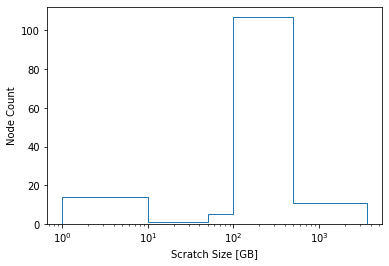

In [7]:
plt.hist(df['scratch_GB'],histtype='step',bins=[1.,10.,50.,100.,500.,df['scratch_GB'].max()])
plt.ylabel('Node Count')
plt.xlabel('Scratch Size [GB]')
plt.xscale('log')
plt.show()

These nodes are

In [31]:
df[df['scratch_GB']<10]

,Host,nproc,RAM,CVMFS,HDFS,scratch,sing,OS,scratch_GB
54,scorpion1,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.9.2009 (Core),9.8
56,scorpion3,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.8.2003 (Core),9.8
58,scorpion5,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.8.2003 (Core),9.8
59,scorpion6,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.9.2009 (Core),9.8
62,scorpion9,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.9.2009 (Core),9.8
64,scorpion11,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.9.2009 (Core),9.8
65,scorpion12,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.9.2009 (Core),9.8
67,scorpion14,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.9.2009 (Core),9.8
70,scorpion17,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.9.2009 (Core),9.8
73,scorpion20,16,23 GB,yes,yes,9.8G,yes,CentOS Linux release 7.9.2009 (Core),9.8


## Categorial Data
We can group the nodes based on various attributes they have.
- We are currently dominated by nodes still running **SL 6**.
- A large majority of nodes have HDFS mounted (which I think implies that they are participating)
- All of the nodes have CVMFS attached (on a good day)
- The SL6 nodes do not have singularity while the C7 nodes do
- All nodes have a minimum of 23 GB RAM and 16 processors

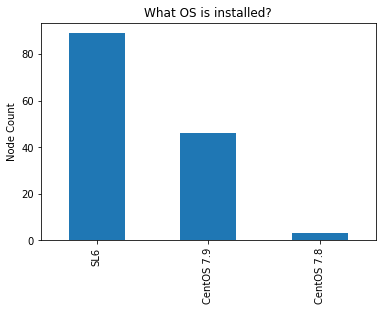

In [56]:
df['OS'].value_counts().plot(kind='bar')
plt.ylabel('Node Count')
plt.title('What OS is installed?')
plt.show()

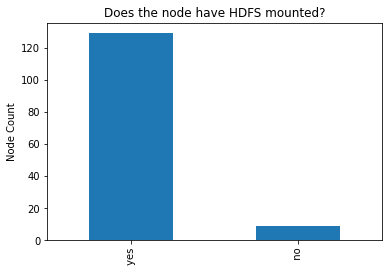

In [53]:
df['HDFS'].value_counts().plot(kind='bar')
plt.ylabel('Node Count')
plt.title('Does the node have HDFS mounted?')
plt.show()

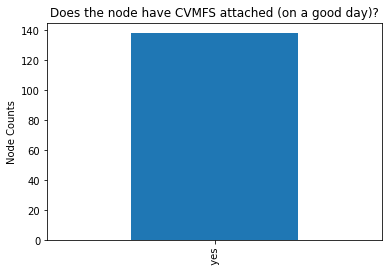

In [52]:
df['CVMFS'].value_counts().plot(kind='bar')
plt.ylabel('Node Counts')
plt.title('Does the node have CVMFS attached (on a good day)?')
plt.show()

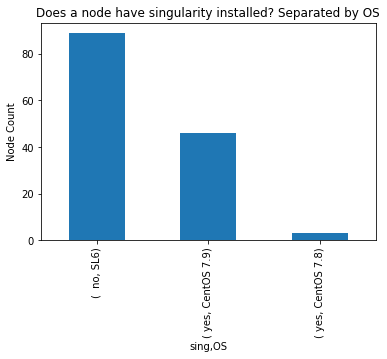

In [63]:
df[['sing','OS']].value_counts().plot(kind='bar')
plt.ylabel('Node Count')
plt.title('Does a node have singularity installed? Separated by OS')
plt.show()

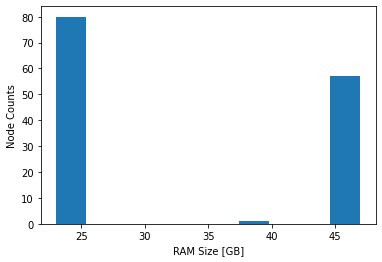

In [48]:
plt.hist(df['ram_GB'])
plt.ylabel('Node Counts')
plt.xlabel('RAM Size [GB]')
plt.show()

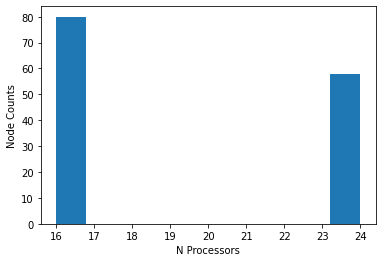

In [51]:
plt.hist(pd.to_numeric(df['nproc']))
plt.ylabel('Node Counts')
plt.xlabel('N Processors')
plt.show()

## Disk Survey
Histograms of nodes and disks participating in HDFS.

In [8]:
pd.read_csv('disk-survey.csv')

,Host,Category,Size
0,cdms-04-1,scratch,223.6G
1,cdms-04-2,scratch,223.6G
2,cdms-04-3,scratch,223.6G
3,cdms-04-4,scratch,223.6G
4,cdms1,/export/data/cdmsdb,1.8T
...,...,...,...
429,twins-b22,hdfs,1.8T
430,twins-b23,scratch,149G
431,twins-b23,hdfs,1.8T
432,twins-b23,hdfs,1.8T


In [9]:
def disk_to_TB(memstr) :
    memstr = memstr.strip()
    factor = 1
    if memstr[-1] == 'T' :
        pass
    elif memstr[-1] == 'G' :
        factor = 1./1000
    else :
        raise ValueError(f'Unknown suffix for {memstr}')
    return float(memstr[0:-1])*factor

df = pd.read_csv('disk-survey.csv')
df['size_TB'] = df.apply(lambda row : disk_to_TB(row['Size']),axis=1)
df

,Host,Category,Size,size_TB
0,cdms-04-1,scratch,223.6G,0.2236
1,cdms-04-2,scratch,223.6G,0.2236
2,cdms-04-3,scratch,223.6G,0.2236
3,cdms-04-4,scratch,223.6G,0.2236
4,cdms1,/export/data/cdmsdb,1.8T,1.8000
...,...,...,...,...
429,twins-b22,hdfs,1.8T,1.8000
430,twins-b23,scratch,149G,0.1490
431,twins-b23,hdfs,1.8T,1.8000
432,twins-b23,hdfs,1.8T,1.8000


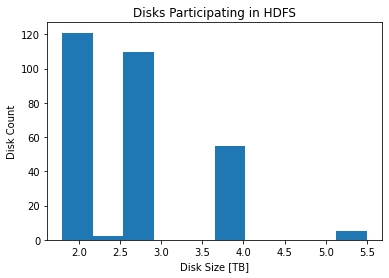

In [10]:
plt.hist(df[df['Category']=='hdfs']['size_TB'])
plt.ylabel('Disk Count')
plt.xlabel('Disk Size [TB]')
plt.title('Disks Participating in HDFS')
plt.show()

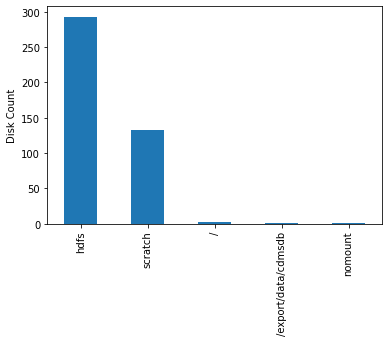

In [11]:
df['Category'].value_counts().plot(kind='bar')
plt.ylabel('Disk Count')
plt.show()

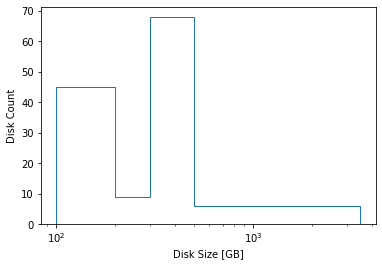

In [14]:
plt.hist(df[df['Category']=='scratch']['size_TB']*1000.,histtype='step',bins=[100.,200.,300.,500.,3500.])
plt.ylabel('Disk Count')
plt.xlabel('Disk Size [GB]')
plt.xscale('log')
plt.show()

<AxesSubplot:>

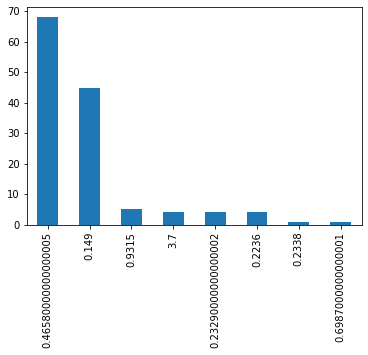

In [18]:
df[df['Category']=='scratch']['size_TB'].value_counts().plot(kind='bar')